# 🚀 XRPUSDT Ensemble Learning - REGRESSION
## Dự đoán GIÁ XRP/USDT với Ensemble Learning

**Mục tiêu**: Xây dựng và so sánh các mô hình Ensemble Learning để dự đoán **GIÁ TRỰC TIẾP** của XRP

**Models**:
- Random Forest Regressor
- XGBoost Regressor
- LightGBM Regressor
- AdaBoost Regressor
- Voting Regressor (kết hợp tất cả)

**Dataset**: XRPUSDT từ 2018-2024 (2,192 ngày)

In [46]:
# Import thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 1. Load và Tiền xử lý Dữ liệu

In [47]:
# Load data
stock_data = pd.read_csv('./data/XRPUSDT20182024new.csv')
stock_data = stock_data[:-100]

# Tiền xử lý
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.drop(columns=['Change %'], errors='ignore', inplace=True)
stock_data = stock_data.sort_values('Date').reset_index(drop=True)

In [48]:
stock_data

,Date,Price,Open,High,Low,Vol
0,2018-09-03,0.3346,0.3420,0.3435,0.3335,199930000.0
1,2018-09-04,0.3308,0.3345,0.3410,0.3290,236220000.0
2,2018-09-05,0.2790,0.3308,0.3338,0.2779,385130000.0
3,2018-09-06,0.3017,0.2789,0.3045,0.2689,315370000.0
4,2018-09-07,0.2870,0.3017,0.3037,0.2813,179700000.0
...,...,...,...,...,...,...
2087,2024-05-22,0.5268,0.5372,0.5382,0.5236,509460000.0
2088,2024-05-23,0.5288,0.5269,0.5456,0.5091,948100000.0
2089,2024-05-24,0.5358,0.5288,0.5372,0.5169,513880000.0
2090,2024-05-25,0.5416,0.5359,0.5425,0.5334,246380000.0


## 2. Feature Engineering Nâng cao

In [49]:
def create_advanced_features(data):
    """
    Tạo các features kỹ thuật cho dự đoán giá cổ phiếu
    """
    feature_data = data.copy()
    
    # ==================== PRICE-BASED FEATURES ====================
    # Returns = % thay đổi giá
    # Đo lợi suất ngắn hạn
    # Thể hiện giá tăng hay giảm và mạnh hay yếu
    feature_data['Return_1d'] = feature_data['Price'].pct_change(1) * 100
    feature_data['Return_3d'] = feature_data['Price'].pct_change(3) * 100
    feature_data['Return_7d'] = feature_data['Price'].pct_change(7) * 100
    
    # Price ranges
    # HL_Range, HL_Range_Pct: độ giao động trong ngày, phản ánh sự giằng co mua bán -> Range lớn -> thị trường biến động mạnh dùng để đo risk/volatility
    feature_data['HL_Range'] = feature_data['High'] - feature_data['Low']
    feature_data['HL_Range_Pct'] = (feature_data['HL_Range'] / feature_data['Low']) * 100
    # OC_Range, OC_Range_Pct: giá bị đẩy mạnh hay bị bán mạnh trong ngày, giúp model nhận biết được ngày breakout/ panic
    feature_data['OC_Range'] = abs(feature_data['Open'] - feature_data['Price'])
    feature_data['OC_Range_Pct'] = (feature_data['OC_Range'] / feature_data['Open']) * 100
    
    # Price position: giá đóng cửa nằm ở đâu trong biên độ ngày: gần HIGH -> phe mua thắng , gần LOW -> phe bán thắng: Cô đọng tâm lý thị trường vào 1 số từ 0 -> 1 
    # Panic là cố gắng bán bằng mọi giá sống sót khi mà giá chứng khoáng giảm
    # Short Sell mượn cổ phiếu sau đó  bán rồi mua lại và trả lại cho công ty
    feature_data['Price_Position'] = (feature_data['Price'] - feature_data['Low']) / feature_data['HL_Range']
    
    # ==================== MOVING AVERAGES ====================
    # SMA: Trung bình giá k ngày : đại diện cho xu hướng ngắn/trung/dài hạn: Gía thường hồi về trung bình -> ML học được mối quan hệ: giá đang quá cao hay quá thấp hơn so với trend
    for period in [5, 7, 10, 14, 20, 30]:
        feature_data[f'SMA_{period}'] = feature_data['Price'].rolling(window=period).mean()
        feature_data[f'Price_to_SMA_{period}'] = (feature_data['Price'] / feature_data[f'SMA_{period}'] - 1) * 100
    
    # EMA phản ứng nhanh hơn SMA: thị trường tài chính thay đổi nhanh EMA giúp model bắt trend sớm
    for period in [5, 10, 20]:
        feature_data[f'EMA_{period}'] = feature_data['Price'].ewm(span=period, adjust=False).mean()
        feature_data[f'Price_to_EMA_{period}'] = (feature_data['Price'] / feature_data[f'EMA_{period}'] - 1) * 100
    
    # ==================== BOLLINGER BANDS ====================
    for period in [10, 20]:
        bb_middle = feature_data['Price'].rolling(window=period).mean()
        bb_std = feature_data['Price'].rolling(window=period).std()
        
        # biên trên/ dưới của giá bình thường
        feature_data[f'BB_Upper_{period}'] = bb_middle + (2 * bb_std)
        feature_data[f'BB_Lower_{period}'] = bb_middle - (2 * bb_std)
        # độ biến động của thị trường -> width lướn -> thị trường bất ổn
        feature_data[f'BB_Width_{period}'] = feature_data[f'BB_Upper_{period}'] - feature_data[f'BB_Lower_{period}']
        # giá đang ở đâu trong band: kết hợp giá + volatility
        feature_data[f'BB_Position_{period}'] = (feature_data['Price'] - feature_data[f'BB_Lower_{period}']) / feature_data[f'BB_Width_{period}']
    
    # ==================== MOMENTUM INDICATORS ====================
    # RSI: đó sức mạnh tăng/ giảm RSI >70: quá mua <30: quá bán rút gọn hành vi giá phức tạp thành 1 chỉ số
    for period in [7, 14]:
        price_delta = feature_data['Price'].diff()
        gain = (price_delta.where(price_delta > 0, 0)).rolling(window=period).mean()
        loss = (-price_delta.where(price_delta < 0, 0)).rolling(window=period).mean()
        rs_ratio = gain / loss
        feature_data[f'RSI_{period}'] = 100 - (100 / (1 + rs_ratio))
    
    # Stochastic : gái hiện tại so với min/max quá khứ -> giá đang ở đỉnh hay đáy cục bộ 
    for period in [14]:
        low_min = feature_data['Low'].rolling(window=period).min()
        high_max = feature_data['High'].rolling(window=period).max()
        feature_data[f'Stoch_{period}'] = 100 * (feature_data['Price'] - low_min) / (high_max - low_min)
    
    # ROC: tốc độ thay đổi giá: Moementum mạnh -> khả năng tiếp diễn xu hướng
    for period in [5, 10]:
        feature_data[f'ROC_{period}'] = ((feature_data['Price'] - feature_data['Price'].shift(period)) / feature_data['Price'].shift(period)) * 100
    
    # ==================== MACD ====================
    # So sánh xu hướng ngắn hạn và dài hạn
    ema_12 = feature_data['Price'].ewm(span=12, adjust=False).mean()
    ema_26 = feature_data['Price'].ewm(span=26, adjust=False).mean()
    feature_data['MACD'] = ema_12 - ema_26
    feature_data['MACD_Signal'] = feature_data['MACD'].ewm(span=9, adjust=False).mean()
    feature_data['MACD_Histogram'] = feature_data['MACD'] - feature_data['MACD_Signal']
    
    # ==================== VOLATILITY ====================
    for period in [5, 10, 20]:
        # Độ rủi ro ngắn hạn
        feature_data[f'Volatility_{period}'] = feature_data['Return_1d'].rolling(window=period).std()
        # Dao động trung bình thực tế
        # giá tăng 1% trong thị trường yên tĩnh khác với trong thị trường hỗn loạn
        feature_data[f'ATR_{period}'] = feature_data['HL_Range'].rolling(window=period).mean()
    
    # ==================== VOLUME FEATURES ====================
    # dòng tiền đột biến
    feature_data['Vol_Change'] = feature_data['Vol'].pct_change() * 100
    
    for period in [5, 10, 20]:
        feature_data[f'Vol_SMA_{period}'] = feature_data['Vol'].rolling(window=period).mean()
        # có tiền lớn vào hay không
        feature_data[f'Vol_Ratio_{period}'] = feature_data['Vol'] / feature_data[f'Vol_SMA_{period}']
    # giá tăng có được ủng hổ bởi volume không
    feature_data['Vol_Price_Corr_20'] = feature_data['Vol'].rolling(window=20).corr(feature_data['Price'])
    
    # ==================== LAG FEATURES ====================
    # TRÍ NHỚ QUÁ KHỨ
    for lag in [1, 2, 3, 5, 7]:
        # thị trường có tính phụ thuộc thời gian
        feature_data[f'Price_Lag_{lag}'] = feature_data['Price'].shift(lag)
        feature_data[f'Return_Lag_{lag}'] = feature_data['Return_1d'].shift(lag)
        feature_data[f'Vol_Lag_{lag}'] = feature_data['Vol'].shift(lag)
    
    # ==================== STATISTICAL FEATURES ====================
    # Mô tả phân phối giá trong một cửa sổ thời gian
    for period in [7, 14, 30]:
        feature_data[f'Price_Mean_{period}'] = feature_data['Price'].rolling(window=period).mean()
        feature_data[f'Price_Std_{period}'] = feature_data['Price'].rolling(window=period).std()
        feature_data[f'Price_Min_{period}'] = feature_data['Price'].rolling(window=period).min()
        feature_data[f'Price_Max_{period}'] = feature_data['Price'].rolling(window=period).max()
        feature_data[f'Price_Range_{period}'] = feature_data[f'Price_Max_{period}'] - feature_data[f'Price_Min_{period}']
    
    # ==================== TIME FEATURES ====================
    feature_data['Day_of_Week'] = feature_data['Date'].dt.dayofweek
    feature_data['Day_of_Month'] = feature_data['Date'].dt.day
    feature_data['Month'] = feature_data['Date'].dt.month
    feature_data['Quarter'] = feature_data['Date'].dt.quarter
    feature_data['Year'] = feature_data['Date'].dt.year
    
    # ==================== TARGET VARIABLE ====================
    # nhãn
    feature_data['Target_Price'] = feature_data['Price'].shift(-1)
    feature_data['Target_Return'] = ((feature_data['Target_Price'] - feature_data['Price']) / feature_data['Price']) * 100
    
    return feature_data

# Tạo features
feature_engineered_data = create_advanced_features(stock_data)

In [50]:
feature_engineered_data.tail()

,Date,Price,Open,High,Low,Vol,Return_1d,Return_3d,Return_7d,HL_Range,...,Price_Min_30,Price_Max_30,Price_Range_30,Day_of_Week,Day_of_Month,Month,Quarter,Year,Target_Price,Target_Return
2087,2024-05-22,0.5268,0.5372,0.5382,0.5236,509460000.0,-1.935964,3.354915,1.502890,0.0146,...,0.4993,0.5445,0.0452,2,22,5,2,2024,0.5288,0.379651
2088,2024-05-23,0.5288,0.5269,0.5456,0.5091,948100000.0,0.379651,-1.655198,2.560124,0.0365,...,0.4993,0.5400,0.0407,3,23,5,2,2024,0.5358,1.323752
2089,2024-05-24,0.5358,0.5288,0.5372,0.5169,513880000.0,1.323752,-0.260611,2.369125,0.0203,...,0.4993,0.5400,0.0407,4,24,5,2,2024,0.5416,1.082493
2090,2024-05-25,0.5416,0.5359,0.5425,0.5334,246380000.0,1.082493,2.809415,3.914045,0.0091,...,0.4993,0.5416,0.0423,5,25,5,2,2024,0.5341,-1.384786
2091,2024-05-26,0.5341,0.5416,0.5418,0.5328,178450000.0,-1.384786,1.002269,4.787130,0.0090,...,0.4993,0.5416,0.0423,6,26,5,2,2024,NaN,NaN


In [51]:
feature_engineered_data.head()
feature_engineered_data.drop(columns=['Target_Return'], errors='ignore', inplace=True)
feature_engineered_data.head()

,Date,Price,Open,High,Low,Vol,Return_1d,Return_3d,Return_7d,HL_Range,...,Price_Std_30,Price_Min_30,Price_Max_30,Price_Range_30,Day_of_Week,Day_of_Month,Month,Quarter,Year,Target_Price
0,2018-09-03,0.3346,0.3420,0.3435,0.3335,199930000.0,NaN,NaN,NaN,0.0100,...,NaN,NaN,NaN,NaN,0,3,9,3,2018,0.3308
1,2018-09-04,0.3308,0.3345,0.3410,0.3290,236220000.0,-1.135684,NaN,NaN,0.0120,...,NaN,NaN,NaN,NaN,1,4,9,3,2018,0.2790
2,2018-09-05,0.2790,0.3308,0.3338,0.2779,385130000.0,-15.659008,NaN,NaN,0.0559,...,NaN,NaN,NaN,NaN,2,5,9,3,2018,0.3017
3,2018-09-06,0.3017,0.2789,0.3045,0.2689,315370000.0,8.136201,-9.832636,NaN,0.0356,...,NaN,NaN,NaN,NaN,3,6,9,3,2018,0.2870
4,2018-09-07,0.2870,0.3017,0.3037,0.2813,179700000.0,-4.872390,-13.240629,NaN,0.0224,...,NaN,NaN,NaN,NaN,4,7,9,3,2018,0.2767


## 3. Chuẩn bị Dữ liệu cho Training (TIME-BASED SPLIT)

In [53]:
# Kiểm tra feature_engineered_data
if 'feature_engineered_data' not in globals():
    raise ValueError("feature_engineered_data chưa được tạo. Chạy cell tạo features trước.")

# Loại bỏ NaN
cleaned_data = feature_engineered_data.dropna()


#### MỚI THÊM ĐỂ TEST
drop_date = pd.to_datetime("2024-05-25")

cleaned_data = cleaned_data[
    cleaned_data['Date'] != drop_date
]
#####

# Kiểm tra dữ liệu sau khi dropna
if len(cleaned_data) == 0:
    raise ValueError(f"cleaned_data rỗng sau dropna(). feature_engineered_data có {len(feature_engineered_data)} dòng, nhưng tất cả đều có NaN.")

# Chọn features (loại bỏ Date, Target columns)
exclude_cols = ['Date', 'Target_Price', 'Target_Return']
feature_columns = [col for col in cleaned_data.columns if col not in exclude_cols]

# Prepare features and target
features = cleaned_data[feature_columns]
target = cleaned_data['Target_Price']

# Kiểm tra features và target
if len(features) == 0:
    raise ValueError(f"features rỗng. cleaned_data có {len(cleaned_data)} dòng.")
if len(target) == 0:
    raise ValueError(f"target rỗng.")

# Time-based split (không shuffle để giữ tính thời gian)
split_idx = int(len(features) * 0.5)
if split_idx == 0:
    raise ValueError(f"split_idx = 0. features chỉ có {len(features)} dòng, cần ít nhất 2 dòng để split.")

train_features, test_features = features[:split_idx], features[split_idx:]
train_target, test_target = target[:split_idx], target[split_idx:]

# Kiểm tra train và test sets
if len(train_features) == 0:
    raise ValueError(f"train_features rỗng. split_idx={split_idx}, features có {len(features)} dòng.")
if len(test_features) == 0:
    raise ValueError(f"test_features rỗng. split_idx={split_idx}, features có {len(features)} dòng.")

# Get date ranges for train and test
train_dates = cleaned_data.loc[train_features.index, 'Date']
test_dates = cleaned_data.loc[test_features.index, 'Date']

# Scaling
feature_scaler = RobustScaler()
scaled_train_features = feature_scaler.fit_transform(train_features)
scaled_test_features = feature_scaler.transform(test_features)

# Convert back to DataFrame
scaled_train_features = pd.DataFrame(scaled_train_features, columns=feature_columns, index=train_features.index)
scaled_test_features = pd.DataFrame(scaled_test_features, columns=feature_columns, index=test_features.index)

In [54]:
cleaned_data.tail()

,Date,Price,Open,High,Low,Vol,Return_1d,Return_3d,Return_7d,HL_Range,...,Price_Std_30,Price_Min_30,Price_Max_30,Price_Range_30,Day_of_Week,Day_of_Month,Month,Quarter,Year,Target_Price
2085,2024-05-20,0.5377,0.5096,0.5379,0.5067,672450000.0,5.493428,2.732136,6.433096,0.0312,...,0.013577,0.4993,0.5562,0.0569,0,20,5,2,2024,0.5372
2086,2024-05-21,0.5372,0.5377,0.5565,0.5321,812410000.0,-0.092989,3.069839,7.440000,0.0244,...,0.013898,0.4993,0.5562,0.0569,1,21,5,2,2024,0.5268
2087,2024-05-22,0.5268,0.5372,0.5382,0.5236,509460000.0,-1.935964,3.354915,1.502890,0.0146,...,0.012268,0.4993,0.5445,0.0452,2,22,5,2,2024,0.5288
2088,2024-05-23,0.5288,0.5269,0.5456,0.5091,948100000.0,0.379651,-1.655198,2.560124,0.0365,...,0.011496,0.4993,0.5400,0.0407,3,23,5,2,2024,0.5358
2089,2024-05-24,0.5358,0.5288,0.5372,0.5169,513880000.0,1.323752,-0.260611,2.369125,0.0203,...,0.011792,0.4993,0.5400,0.0407,4,24,5,2,2024,0.5416


In [35]:
test_target

1060    0.7516
1061    0.7443
1062    0.7248
1063    0.7386
1064    0.7132
         ...  
2086    0.5268
2087    0.5288
2088    0.5358
2089    0.5416
2090    0.5341
Name: Target_Price, Length: 1031, dtype: float64

In [43]:
import pandas as pd
import numpy as np

# Đọc file CSV
df = pd.read_csv('./data/XRPUSDT_train.csv')

# Chuyển cột Date thành datetime
df['Date'] = pd.to_datetime(df['Date'])

# Tìm dòng có Date = 25/5/2024
target_date = pd.to_datetime('2024-05-25')

# Kiểm tra xem ngày đó có tồn tại không
if target_date in df['Date'].values:
    # Cách 1: Sửa bằng loc
    df.loc[df['Date'] == target_date, 'Target_Price'] = np.nan  # Thay giá trị mới
    df.loc[df['Date'] == target_date, 'RF_Pred_Tomorrow'] = np.nan
    df.loc[df['Date'] == target_date, 'RF_Pred_Today'] = 0.5484476675525032
    # Lưu file lại
    df.to_csv('./data/XRPUSDT_train.csv', index=False)
    print(f"✓ Đã sửa Target_Price cho ngày {target_date.date()}")
    print(df[df['Date'] == target_date][['Date', 'Price', 'Target_Price']])
else:
    print(f"❌ Không tìm thấy ngày {target_date.date()} trong file")

# Hiển thị các dòng gần ngày đó để kiểm tra
print("\nDữ liệu xung quanh ngày 25/5/2024:")
print(df[(df['Date'] >= '2024-05-23') & (df['Date'] <= '2024-05-27')][['Date', 'Price', 'Target_Price']])

✓ Đã sửa Target_Price cho ngày 2024-05-25
           Date   Price  Target_Price
2061 2024-05-25  0.5416           NaN

Dữ liệu xung quanh ngày 25/5/2024:
           Date   Price  Target_Price
2059 2024-05-23  0.5288        0.5358
2060 2024-05-24  0.5358        0.5416
2061 2024-05-25  0.5416           NaN


## Train voi 2 layer

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

scaled_train_features = scaled_train_features.dropna()
layer1_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=8,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)

layer1_model.fit(scaled_train_features, train_target)

cleaned_data.loc[train_features.index, 'RF_Pred_Tomorrow'] = layer1_model.predict(scaled_train_features)
cleaned_data.loc[test_features.index, 'RF_Pred_Tomorrow'] = layer1_model.predict(scaled_test_features)

# RF dự đoán Close[t+1] tại ngày t
# → dùng cho ngày t+1
cleaned_data['RF_Pred_Today'] = cleaned_data['RF_Pred_Tomorrow'].shift(1)

cleaned_data.tail()


,Date,Price,Open,High,Low,Vol,Return_1d,Return_3d,Return_7d,HL_Range,...,Price_Max_30,Price_Range_30,Day_of_Week,Day_of_Month,Month,Quarter,Year,Target_Price,RF_Pred_Tomorrow,RF_Pred_Today
2085,2024-05-20,0.5377,0.5096,0.5379,0.5067,672450000.0,5.493428,2.732136,6.433096,0.0312,...,0.5562,0.0569,0,20,5,2,2024,0.5372,0.548333,0.503016
2086,2024-05-21,0.5372,0.5377,0.5565,0.5321,812410000.0,-0.092989,3.069839,7.440000,0.0244,...,0.5562,0.0569,1,21,5,2,2024,0.5268,0.550215,0.548333
2087,2024-05-22,0.5268,0.5372,0.5382,0.5236,509460000.0,-1.935964,3.354915,1.502890,0.0146,...,0.5445,0.0452,2,22,5,2,2024,0.5288,0.545340,0.550215
2088,2024-05-23,0.5288,0.5269,0.5456,0.5091,948100000.0,0.379651,-1.655198,2.560124,0.0365,...,0.5400,0.0407,3,23,5,2,2024,0.5358,0.546486,0.545340
2089,2024-05-24,0.5358,0.5288,0.5372,0.5169,513880000.0,1.323752,-0.260611,2.369125,0.0203,...,0.5400,0.0407,4,24,5,2,2024,0.5416,0.548235,0.546486


In [56]:
new_row = {
    'Date': pd.to_datetime('2024-05-25'),
    'Price': 0.5416,
    'Open':  0.5359,
    'High':  0.5425,
    'Low':   0.5334,
    'Vol':   246380000
}

stock_data = pd.concat(
    [stock_data, pd.DataFrame([new_row])],
    ignore_index=True
)
feature_data = create_advanced_features(stock_data)
latest_row = feature_data.iloc[-1]

X_future = latest_row[feature_columns].to_frame().T
X_future_scaled = feature_scaler.transform(X_future)

pred_price_27_5 = layer1_model.predict(X_future_scaled)[0]

print(f"📌 Dự đoán giá cho ngày 26/05/2024: {pred_price_27_5:.4f}")



📌 Dự đoán giá cho ngày 26/05/2024: 0.5485


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [37]:
cleaned_data.to_csv('./data/XRPUSDT_train.csv', index=False)

In [41]:
cleaned_data

,Date,Price,Open,High,Low,Vol,Return_1d,Return_3d,Return_7d,HL_Range,...,Price_Max_30,Price_Range_30,Day_of_Week,Day_of_Month,Month,Quarter,Year,Target_Price,RF_Pred_Tomorrow,RF_Pred_Today
29,2018-10-02,0.5170,0.5773,0.5798,0.5157,439890000.0,-10.460686,-9.266409,-1.654936,0.0641,...,0.5827,0.3197,1,2,10,4,2018,0.5285,0.526018,NaN
30,2018-10-03,0.5285,0.5169,0.5372,0.5082,556330000.0,2.224371,-9.301527,3.101834,0.0290,...,0.5827,0.3197,2,3,10,4,2018,0.5287,0.546475,0.526018
31,2018-10-04,0.5287,0.5286,0.5490,0.5241,320580000.0,0.037843,-8.434361,-2.669367,0.0249,...,0.5827,0.3197,3,4,10,4,2018,0.5209,0.547125,0.546475
32,2018-10-05,0.5209,0.5287,0.5326,0.5107,332770000.0,-1.475317,0.754352,-3.483417,0.0219,...,0.5827,0.3197,4,5,10,4,2018,0.4888,0.519308,0.547125
33,2018-10-06,0.4888,0.5209,0.5218,0.4691,376590000.0,-6.162411,-7.511826,-14.215514,0.0527,...,0.5827,0.3197,5,6,10,4,2018,0.4825,0.489116,0.519308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,2024-05-21,0.5372,0.5377,0.5565,0.5321,812410000.0,-0.092989,3.069839,7.440000,0.0244,...,0.5562,0.0569,1,21,5,2,2024,0.5268,0.550244,0.548280
2087,2024-05-22,0.5268,0.5372,0.5382,0.5236,509460000.0,-1.935964,3.354915,1.502890,0.0146,...,0.5445,0.0452,2,22,5,2,2024,0.5288,0.544913,0.550244
2088,2024-05-23,0.5288,0.5269,0.5456,0.5091,948100000.0,0.379651,-1.655198,2.560124,0.0365,...,0.5400,0.0407,3,23,5,2,2024,0.5358,0.546345,0.544913
2089,2024-05-24,0.5358,0.5288,0.5372,0.5169,513880000.0,1.323752,-0.260611,2.369125,0.0203,...,0.5400,0.0407,4,24,5,2,2024,0.5416,0.548448,0.546345


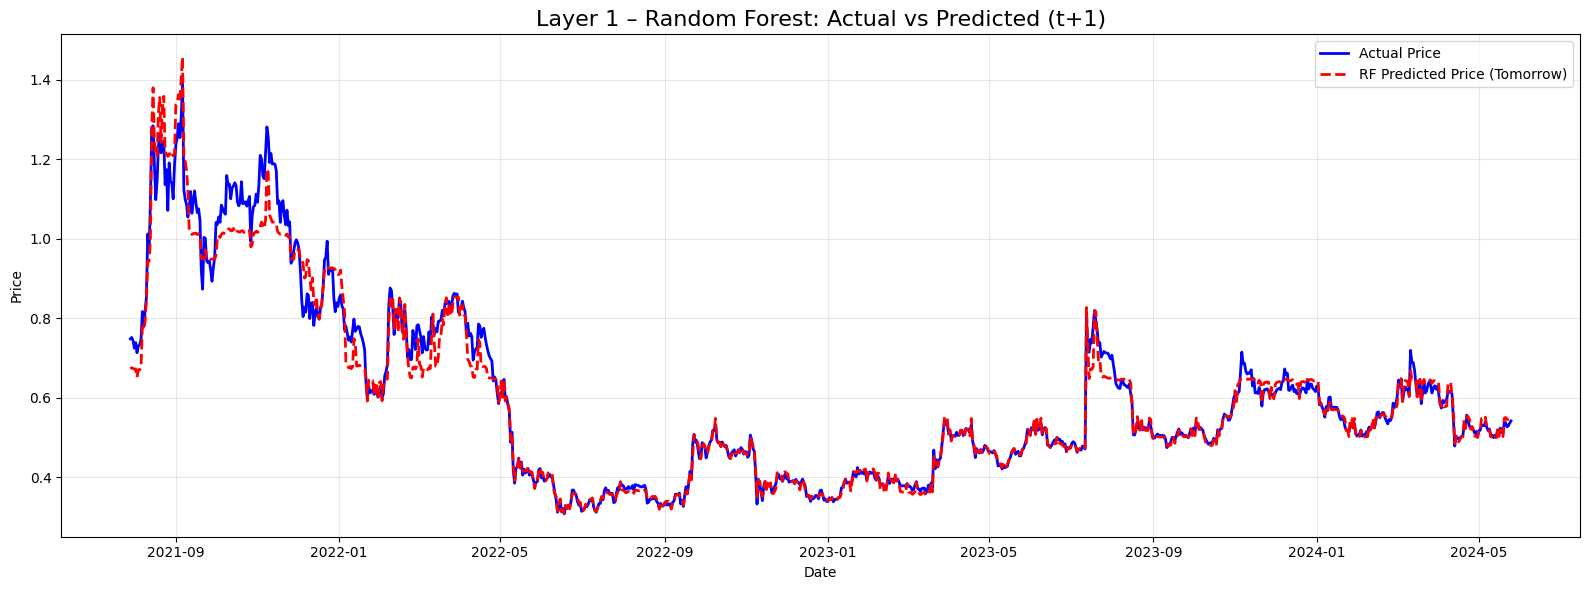

In [9]:
# ===== Data để vẽ (test set) =====
plot_data = cleaned_data.loc[test_features.index, [
    'Date',
    'Price',
    'RF_Pred_Tomorrow'
]].dropna()

plt.figure(figsize=(16, 6))

# Giá thật
plt.plot(
    plot_data['Date'],
    plot_data['Price'],
    label='Actual Price',
    linewidth=2,
    color='blue'
)

# RF dự đoán ngày mai
plt.plot(
    plot_data['Date'],
    plot_data['RF_Pred_Tomorrow'],
    label='RF Predicted Price (Tomorrow)',
    linewidth=2,
    linestyle='--',
    color='red'
)

plt.title('Layer 1 – Random Forest: Actual vs Predicted (t+1)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()




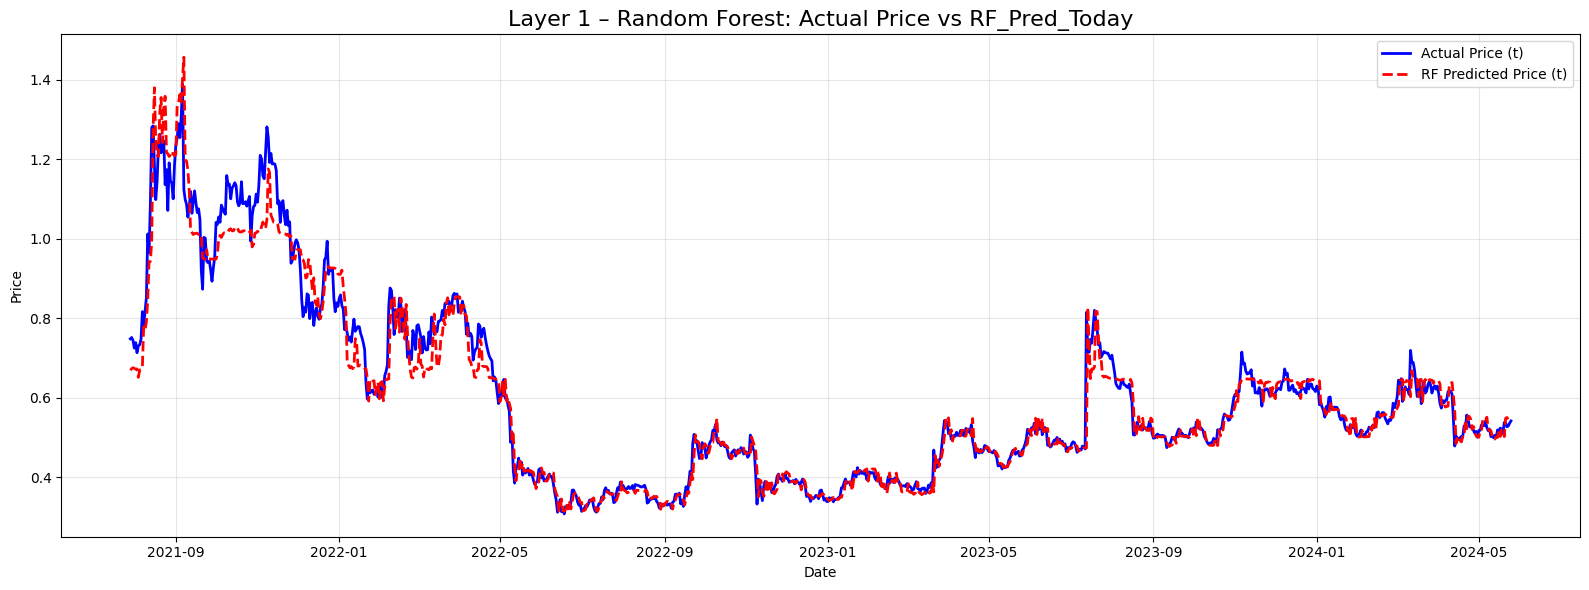

In [10]:
# ===== Data để vẽ (test set) =====
plot_data = cleaned_data.loc[test_features.index, [
    'Date',
    'Price',
    'RF_Pred_Today'
]].dropna()

plt.figure(figsize=(16, 6))

# Giá thật tại ngày t
plt.plot(
    plot_data['Date'],
    plot_data['Price'],
    label='Actual Price (t)',
    linewidth=2,
    color='blue'
)

# RF dự đoán cho ngày t (được tạo từ t-1)
plt.plot(
    plot_data['Date'],
    plot_data['RF_Pred_Today'],
    label='RF Predicted Price (t)',
    linewidth=2,
    linestyle='--',
    color='red'
)

plt.title('Layer 1 – Random Forest: Actual Price vs RF_Pred_Today', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ===== Lấy dữ liệu test hợp lệ =====
eval_data = cleaned_data.loc[test_features.index, [
    'Price',
    'RF_Pred_Today'
]].dropna()

y_true = eval_data['Price']
y_pred = eval_data['RF_Pred_Today']

# ===== Các metric =====
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

# ===== In kết quả =====
print("📈 Random Forest – Layer 1 Performance (Test Set)")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")


📈 Random Forest – Layer 1 Performance (Test Set)
MAE  : 0.0292
RMSE : 0.0474
MAPE : 4.25%
R²   : 0.9572


In [12]:
print(cleaned_data['Price'].describe())


count    2062.000000
mean        0.493385
std         0.270833
min         0.136000
25%         0.302425
50%         0.427450
75%         0.606975
max         1.836300
Name: Price, dtype: float64


In [8]:
# df_clean[['Target_Price','Price','RF_Pred_Tomorrow','RF_Pred_Today']].head(20)
# df_clean.drop(columns=['RF_Pred_Tomorrow'], inplace=True)
# df_clean.drop(columns=['Target_Price'], inplace=True)
df_clean = cleaned_data.copy()
df_clean.dropna(inplace=True)
df_clean.head()


,Date,Price,Open,High,Low,Vol,Return_1d,Return_3d,Return_7d,HL_Range,...,Price_Range_30,Day_of_Week,Day_of_Month,Month,Quarter,Year,Target_Price,Target_Return,RF_Pred_Tomorrow,RF_Pred_Today
30,2018-10-03,0.5285,0.5169,0.5372,0.5082,556330000.0,2.224371,-9.301527,3.101834,0.0290,...,0.3197,2,3,10,4,2018,0.5287,0.037843,0.546475,0.526018
31,2018-10-04,0.5287,0.5286,0.5490,0.5241,320580000.0,0.037843,-8.434361,-2.669367,0.0249,...,0.3197,3,4,10,4,2018,0.5209,-1.475317,0.547125,0.546475
32,2018-10-05,0.5209,0.5287,0.5326,0.5107,332770000.0,-1.475317,0.754352,-3.483417,0.0219,...,0.3197,4,5,10,4,2018,0.4888,-6.162411,0.519308,0.547125
33,2018-10-06,0.4888,0.5209,0.5218,0.4691,376590000.0,-6.162411,-7.511826,-14.215514,0.0527,...,0.3197,5,6,10,4,2018,0.4825,-1.288871,0.489116,0.519308
34,2018-10-07,0.4825,0.4889,0.4903,0.4685,282520000.0,-1.288871,-8.738415,-17.195813,0.0218,...,0.3197,6,7,10,4,2018,0.4923,2.031088,0.482388,0.489116


In [9]:
# layer2_features = [
#     'Open',
#     'High',
#     'Low',
#     'Vol',
#     'RF_Pred_Today'
# ]

layer2_features = [
    'Open',
    'Vol',
    'RF_Pred_Today'
]

df_clean['Target_Close_Today'] = df_clean['Price']
df_l2 = df_clean.dropna(subset=layer2_features + ['Target_Close_Today'])

X2 = df_l2[layer2_features]
y2 = df_l2['Target_Close_Today']

split_idx = int(len(X2) * 0.5)

X2_train, X2_test = X2[:split_idx], X2[split_idx:]
y2_train, y2_test = y2[:split_idx], y2[split_idx:]


from sklearn.linear_model import Ridge

l2_model = Ridge(alpha=1.0)
l2_model.fit(X2_train, y2_train)

y2_pred = l2_model.predict(X2_test)

from sklearn.metrics import mean_absolute_error

mae_l2 = mean_absolute_error(y2_test, y2_pred)
direction_acc = (
    np.sign(y2_test.diff().dropna()) ==
    np.sign(pd.Series(y2_pred, index=y2_test.index).diff().dropna())
).mean() * 100

print("\n" + "="*80)
print("LAYER 2 PERFORMANCE")
print("="*80)
print(f"MAE: {mae_l2:.6f}")
print(f"Direction Accuracy: {direction_acc:.2f}%")




LAYER 2 PERFORMANCE
MAE: 0.021633
Direction Accuracy: 42.04%


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.91322e-24): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


In [11]:
print("\n" + "=" * 80)
print("ACTUAL vs PREDICTED - LAYER 2 (Ridge)")
print("=" * 80)

# Series dự đoán
y2_pred_series = pd.Series(
    y2_pred,
    index=y2_test.index,
    name='Predicted_Close'
)

# DataFrame so sánh
comparison_l2 = pd.DataFrame({
    'Date': df_l2.loc[y2_test.index, 'Date'],
    'Actual_Close': y2_test.values,
    'Predicted_Close': y2_pred_series.values
})

comparison_l2['Error'] = comparison_l2['Actual_Close'] - comparison_l2['Predicted_Close']
comparison_l2['Error_Pct'] = comparison_l2['Error'] / comparison_l2['Actual_Close'] * 100



ACTUAL vs PREDICTED - LAYER 2 (Ridge)


In [12]:
print(f"\nTest Period: {comparison_l2['Date'].min().date()} → {comparison_l2['Date'].max().date()}")
print(f"Total samples: {len(comparison_l2)}")

display(
    comparison_l2.head(10).style.format({
        'Actual_Close': '{:.4f}',
        'Predicted_Close': '{:.4f}',
        'Error': '{:.4f}',
        'Error_Pct': '{:.2f}%'
    })
)




Test Period: 2021-07-29 → 2024-05-25
Total samples: 1031


,Date,Actual_Close,Predicted_Close,Error,Error_Pct
1060,2021-07-29 00:00:00,0.7482,0.6969,0.0513,6.85%
1061,2021-07-30 00:00:00,0.7516,0.7060,0.0456,6.07%
1062,2021-07-31 00:00:00,0.7443,0.7091,0.0352,4.73%
1063,2021-08-01 00:00:00,0.7248,0.7045,0.0203,2.80%
1064,2021-08-02 00:00:00,0.7386,0.6939,0.0447,6.05%
1065,2021-08-03 00:00:00,0.7132,0.7010,0.0122,1.71%
1066,2021-08-04 00:00:00,0.7306,0.6780,0.0526,7.20%
1067,2021-08-05 00:00:00,0.7331,0.6960,0.0371,5.06%
1068,2021-08-06 00:00:00,0.7469,0.6972,0.0497,6.66%
1069,2021-08-07 00:00:00,0.8167,0.7073,0.1094,13.39%


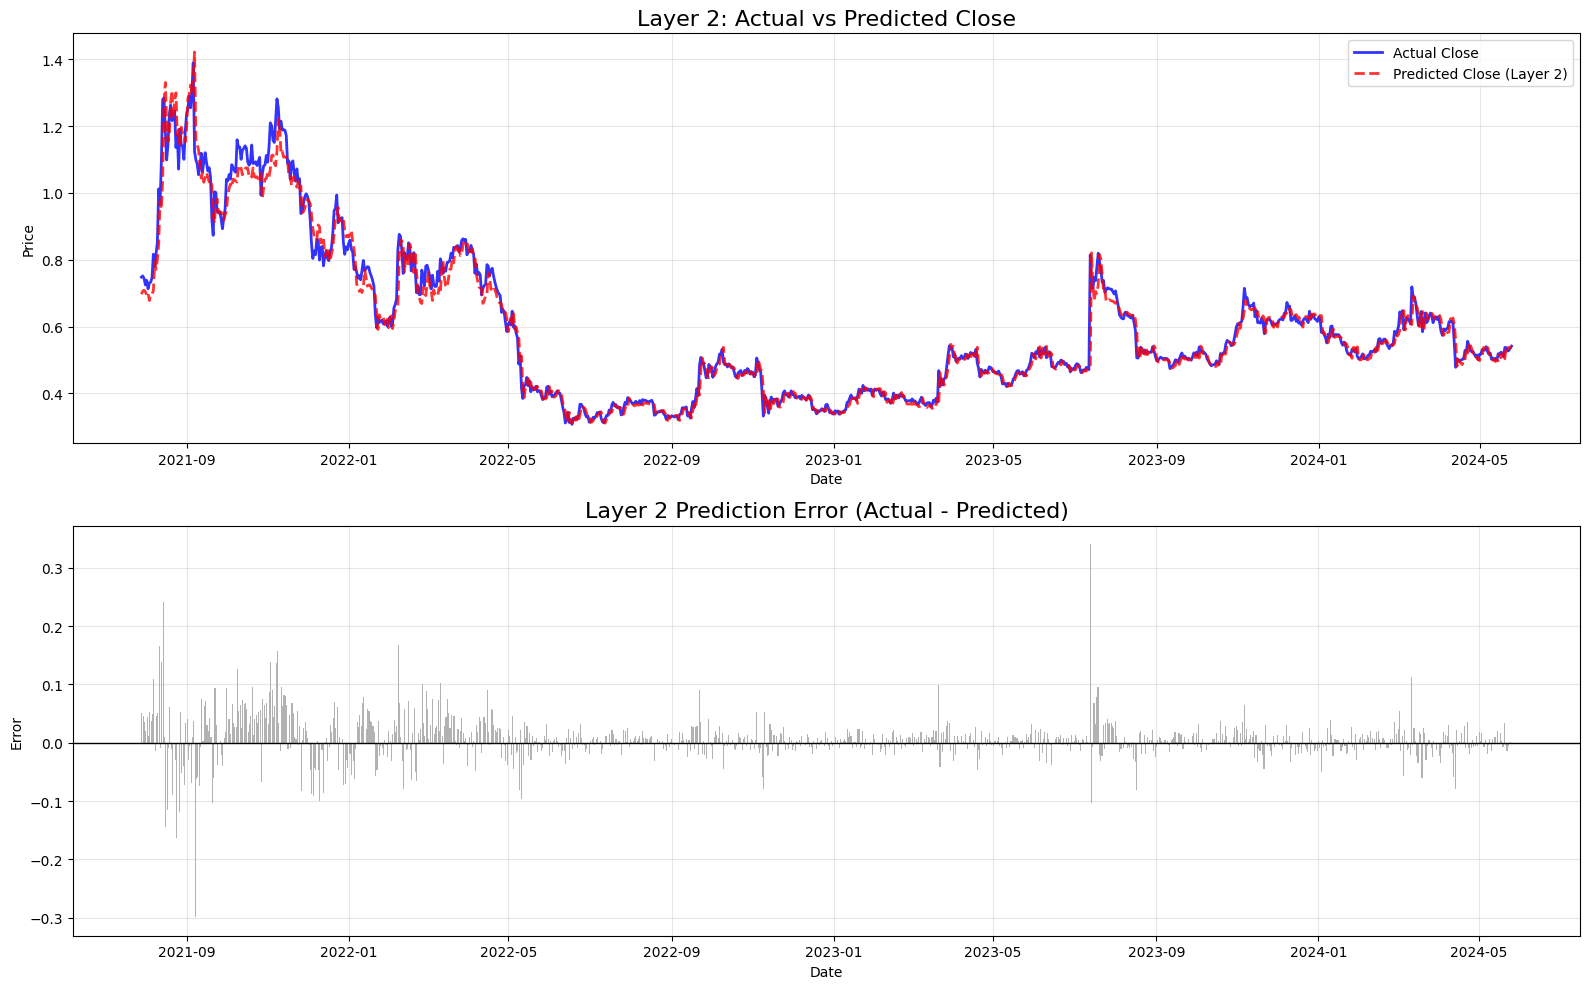

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# ===== Plot 1: Actual vs Predicted =====
ax1 = axes[0]
ax1.plot(
    comparison_l2['Date'],
    comparison_l2['Actual_Close'],
    label='Actual Close',
    linewidth=2,
    alpha=0.8,
    color='blue'          # 🔵 đường xanh
)
ax1.plot(
    comparison_l2['Date'],
    comparison_l2['Predicted_Close'],
    label='Predicted Close (Layer 2)',
    linewidth=2,
    linestyle='--',
    alpha=0.8,
    color='red'           # 🔴 đường đỏ
)

ax1.set_title('Layer 2: Actual vs Predicted Close', fontsize=16)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(alpha=0.3)

# ===== Plot 2: Prediction Error =====
ax2 = axes[1]
ax2.bar(
    comparison_l2['Date'],
    comparison_l2['Error'],
    alpha=0.6,
    color='gray'
)
ax2.axhline(0, color='black', linewidth=1)

ax2.set_title('Layer 2 Prediction Error (Actual - Predicted)', fontsize=16)
ax2.set_xlabel('Date')
ax2.set_ylabel('Error')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [14]:
print("\n" + "=" * 80)
print("LAYER 2 ERROR STATISTICS")
print("=" * 80)

print(f"Mean Error:        {comparison_l2['Error'].mean():.6f}")
print(f"Mean Abs Error:    {comparison_l2['Error'].abs().mean():.6f}")
print(f"Max Error:         {comparison_l2['Error'].max():.6f}")
print(f"Min Error:         {comparison_l2['Error'].min():.6f}")
print(f"Std Error:         {comparison_l2['Error'].std():.6f}")

print(f"\nMean Error %:      {comparison_l2['Error_Pct'].mean():.2f}%")
print(f"Mean Abs Error %:  {comparison_l2['Error_Pct'].abs().mean():.2f}%")



LAYER 2 ERROR STATISTICS
Mean Error:        0.005826
Mean Abs Error:    0.021633
Max Error:         0.340096
Min Error:         -0.298831
Std Error:         0.035486

Mean Error %:      0.70%
Mean Abs Error %:  3.30%


In [16]:
# ===== Thêm vào cell trước cell gặp lỗi =====

# df_features là copy của cleaned_data hoặc df_clean
df_features = cleaned_data.copy()
# hoặc
# df_features = df_clean.copy()

df_features = df_features.sort_values('Date').reset_index(drop=True)

# Target đa horizon
df_features['Target_Price_3D'] = df_features['Price'].shift(-3)
df_features['Target_Price_5D'] = df_features['Price'].shift(-5)
df_features['Target_Price_7D'] = df_features['Price'].shift(-7)

targets = {
    '3D': 'Target_Price_3D',
    '5D': 'Target_Price_5D',
    '7D': 'Target_Price_7D'
}

datasets = {}

for horizon, target_col in targets.items():
    print("\n" + "=" * 80)
    print(f"CHUẨN BỊ DATASET – DỰ ĐOÁN {horizon}")
    print("=" * 80)

    # Drop NaN riêng cho từng target
    df_clean_h = df_features.dropna(subset=feature_columns + [target_col])

    X_h = df_clean_h[feature_columns]
    y_h = df_clean_h[target_col]
    # ...existing code...


CHUẨN BỊ DATASET – DỰ ĐOÁN 3D

CHUẨN BỊ DATASET – DỰ ĐOÁN 5D

CHUẨN BỊ DATASET – DỰ ĐOÁN 7D


In [17]:
df_features = df_features.sort_values('Date').reset_index(drop=True)

# Target đa horizon
df_features['Target_Price_3D'] = df_features['Price'].shift(-3)
df_features['Target_Price_5D'] = df_features['Price'].shift(-5)
df_features['Target_Price_7D'] = df_features['Price'].shift(-7)

targets = {
    '3D': 'Target_Price_3D',
    '5D': 'Target_Price_5D',
    '7D': 'Target_Price_7D'
}


datasets = {}

for horizon, target_col in targets.items():
    print("\n" + "=" * 80)
    print(f"CHUẨN BỊ DATASET – DỰ ĐOÁN {horizon}")
    print("=" * 80)

    # Drop NaN riêng cho từng target
    df_clean_h = df_features.dropna(subset=feature_columns + [target_col])

    X_h = df_clean_h[feature_columns]
    y_h = df_clean_h[target_col]

    split_idx = int(len(X_h) * 0.4)
    X_train_h, X_test_h = X_h[:split_idx], X_h[split_idx:]
    y_train_h, y_test_h = y_h[:split_idx], y_h[split_idx:]

    # Dates
    train_dates_h = df_clean_h.loc[X_train_h.index, 'Date']
    test_dates_h  = df_clean_h.loc[X_test_h.index, 'Date']

    # Scaling
    scaler_h = RobustScaler()
    X_train_scaled_h = scaler_h.fit_transform(X_train_h)
    X_test_scaled_h  = scaler_h.transform(X_test_h)

    X_train_scaled_h = pd.DataFrame(
        X_train_scaled_h,
        columns=feature_columns,
        index=X_train_h.index
    )
    X_test_scaled_h = pd.DataFrame(
        X_test_scaled_h,
        columns=feature_columns,
        index=X_test_h.index
    )

    datasets[horizon] = {
        'X_train': X_train_scaled_h,
        'X_test': X_test_scaled_h,
        'y_train': y_train_h,
        'y_test': y_test_h,
        'train_dates': train_dates_h,
        'test_dates': test_dates_h,
        'scaler': scaler_h
    }
    print(f"✓ Samples: Train={len(X_train_h)}, Test={len(X_test_h)}")
    print(f"✓ Period test: {test_dates_h.min().date()} → {test_dates_h.max().date()}")




CHUẨN BỊ DATASET – DỰ ĐOÁN 3D
✓ Samples: Train=823, Test=1236
✓ Period test: 2021-01-02 → 2024-05-22

CHUẨN BỊ DATASET – DỰ ĐOÁN 5D
✓ Samples: Train=822, Test=1235
✓ Period test: 2021-01-01 → 2024-05-20

CHUẨN BỊ DATASET – DỰ ĐOÁN 7D
✓ Samples: Train=822, Test=1233
✓ Period test: 2021-01-01 → 2024-05-18


In [20]:
from sklearn.ensemble import RandomForestRegressor

horizon_models = {}

for horizon in ['3D', '5D', '7D']:
    data = datasets[horizon]

    model = RandomForestRegressor(
        n_estimators=500,
        max_depth=8,
        min_samples_leaf=20,
        random_state=42,
        n_jobs=-1
    )

    model.fit(data['X_train'], data['y_train'])
    horizon_models[horizon] = model


In [22]:
predictions = {}

for horizon in ['3D', '5D', '7D']:
    data = datasets[horizon]
    model = horizon_models[horizon] 

    y_pred = model.predict(data['X_test'])

    predictions[horizon] = pd.DataFrame({
        'Date': data['test_dates'].values,
        'Actual_Price': data['y_test'].values,
        'Predicted_Price': y_pred
    })

    predictions[horizon]['Error'] = (
        predictions[horizon]['Actual_Price']
        - predictions[horizon]['Predicted_Price']
    )


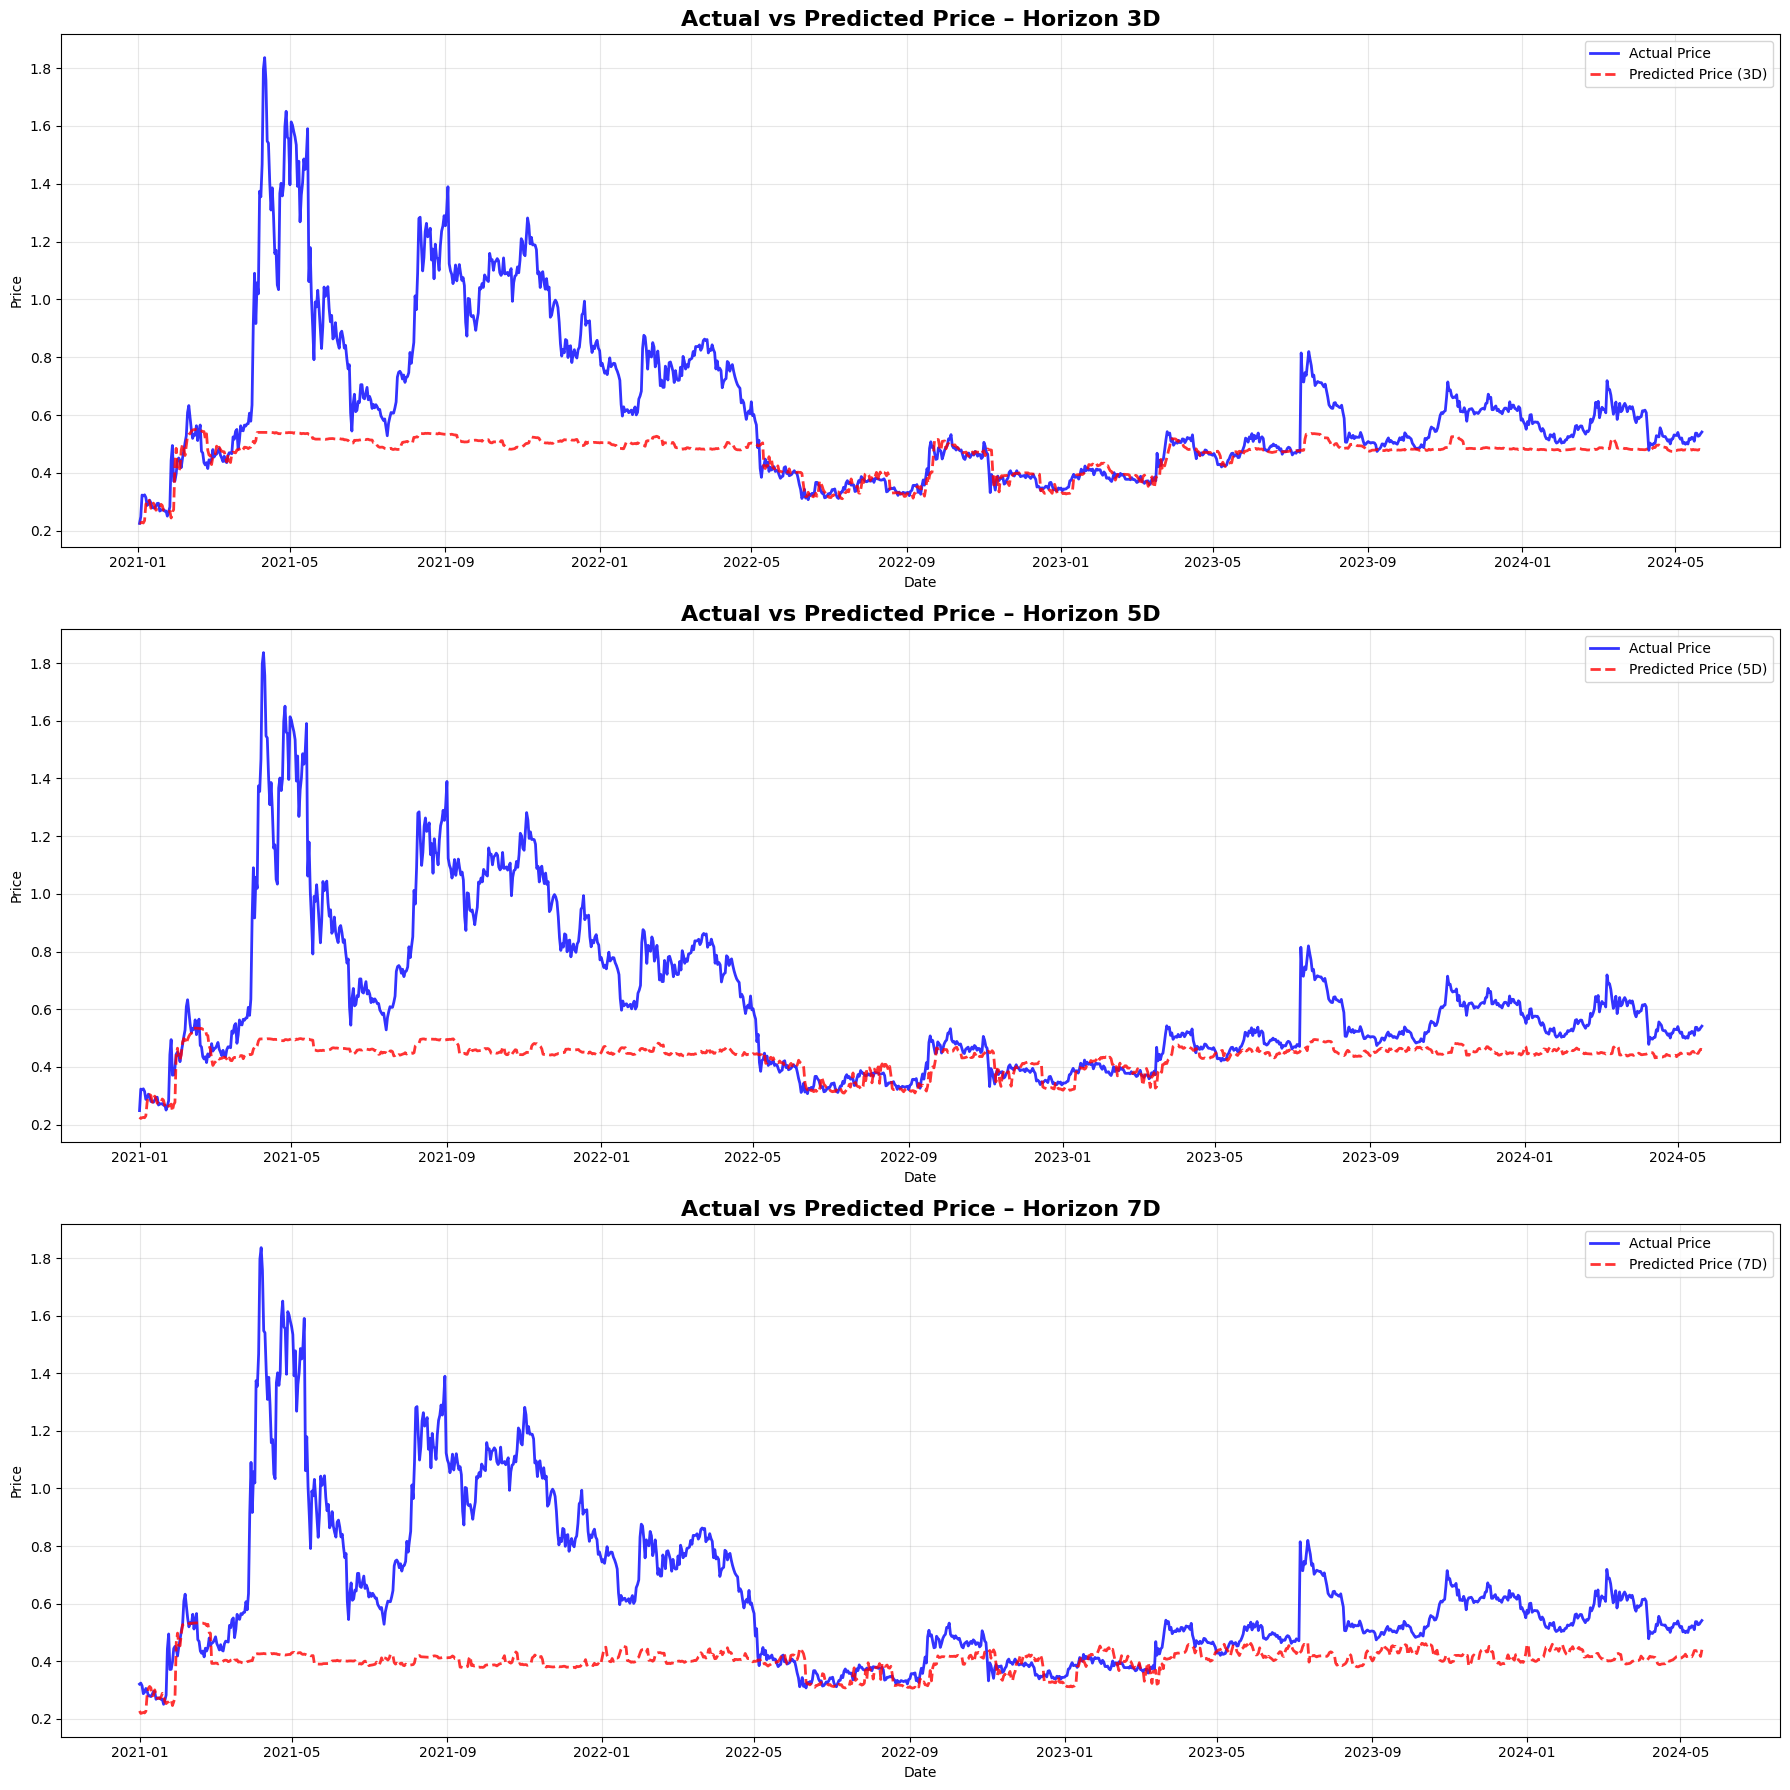

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(18, 18), sharex=False)

for ax, horizon in zip(axes, ['3D', '5D', '7D']):
    df_plot = predictions[horizon]

    # ===== Actual =====
    ax.plot(
        df_plot['Date'],
        df_plot['Actual_Price'],
        label='Actual Price',
        linewidth=2,
        color='blue',
        alpha=0.8
    )

    # ===== Predicted =====
    ax.plot(
        df_plot['Date'],
        df_plot['Predicted_Price'],
        label=f'Predicted Price ({horizon})',
        linewidth=2,
        linestyle='--',
        color='red',
        alpha=0.8
    )

    ax.set_title(
        f'Actual vs Predicted Price – Horizon {horizon}',
        fontsize=16,
        fontweight='bold'
    )
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Common samples: 1232


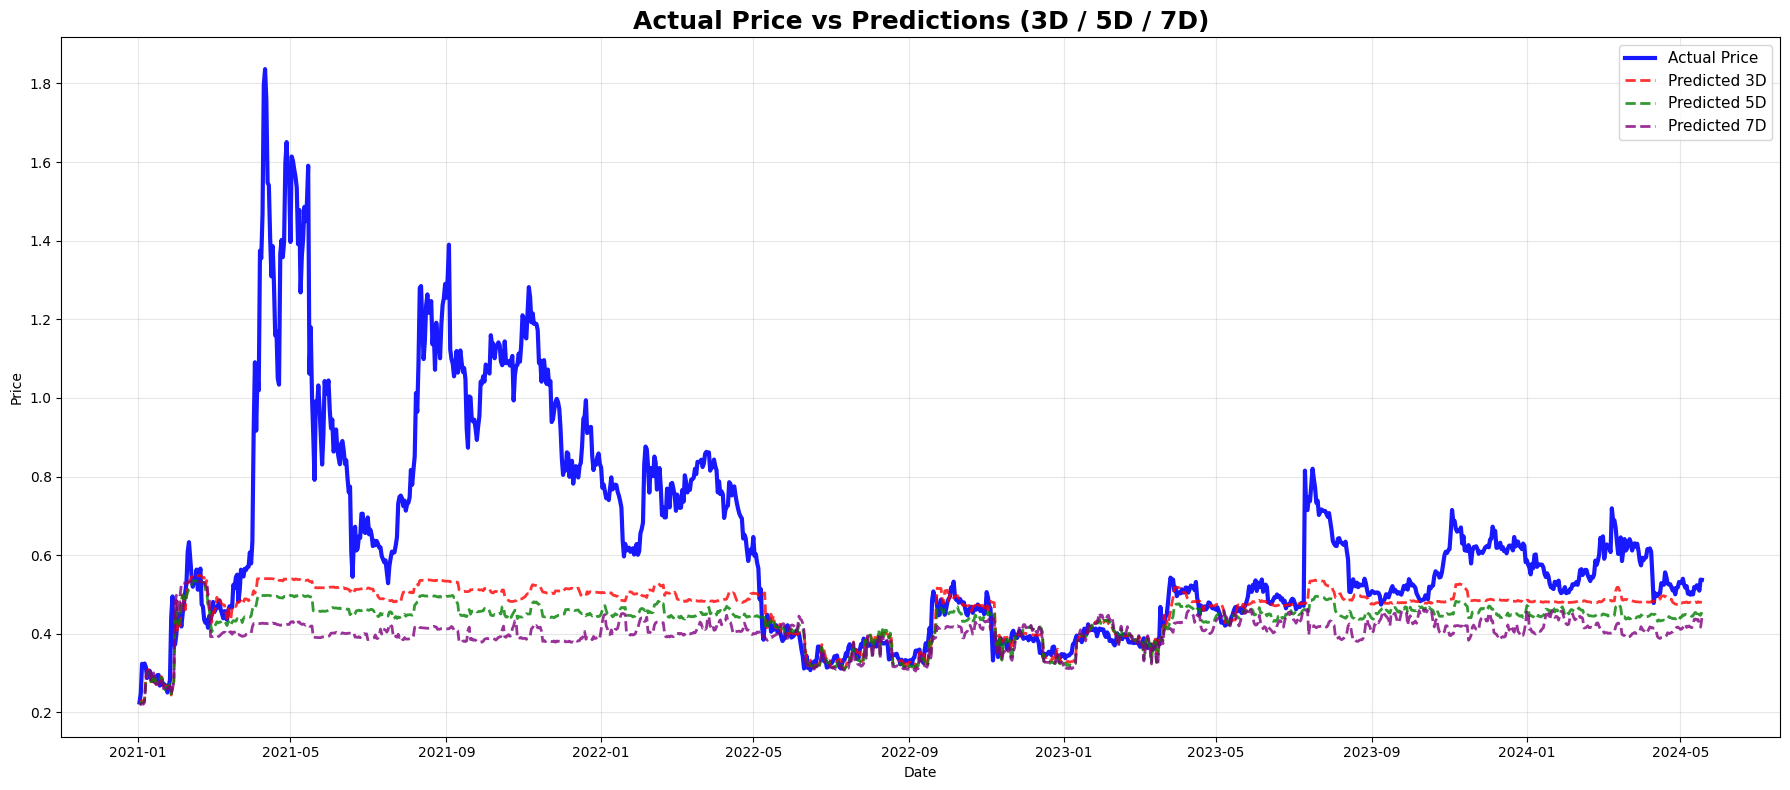

In [24]:
# Merge predictions on Date
df_all = (
    predictions['3D'][['Date', 'Predicted_Price']]
        .rename(columns={'Predicted_Price': 'Pred_3D'})
    .merge(
        predictions['5D'][['Date', 'Predicted_Price']]
            .rename(columns={'Predicted_Price': 'Pred_5D'}),
        on='Date',
        how='inner'
    )
    .merge(
        predictions['7D'][['Date', 'Predicted_Price']]
            .rename(columns={'Predicted_Price': 'Pred_7D'}),
        on='Date',
        how='inner'
    )
)

# Add actual price (lấy từ 3D, vì Date giống nhau)
df_all = df_all.merge(
    predictions['3D'][['Date', 'Actual_Price']],
    on='Date',
    how='inner'
)

print(f"Common samples: {len(df_all)}")
df_all.head()
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))

# ===== ACTUAL =====
plt.plot(
    df_all['Date'],
    df_all['Actual_Price'],
    label='Actual Price',
    color='blue',
    linewidth=3,
    alpha=0.9
)

# ===== PRED 3D =====
plt.plot(
    df_all['Date'],
    df_all['Pred_3D'],
    label='Predicted 3D',
    color='red',
    linestyle='--',
    linewidth=2,
    alpha=0.8
)

# ===== PRED 5D =====
plt.plot(
    df_all['Date'],
    df_all['Pred_5D'],
    label='Predicted 5D',
    color='green',
    linestyle='--',
    linewidth=2,
    alpha=0.8
)

# ===== PRED 7D =====
plt.plot(
    df_all['Date'],
    df_all['Pred_7D'],
    label='Predicted 7D',
    color='purple',
    linestyle='--',
    linewidth=2,
    alpha=0.8
)

plt.title(
    'Actual Price vs Predictions (3D / 5D / 7D)',
    fontsize=18,
    fontweight='bold'
)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
